# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

In [20]:
from torch.utils.data import DataLoader

In [2]:
from model import *
from dataloader import *
from shift import *

In [3]:
data = pd.read_csv('MLTempDataset1.csv')
data.head(4)

,Unnamed: 0,Datetime,Hourly_Temp
0,0,2022-01-04 00:00:00,20.867
1,1,2022-01-04 01:00:00,21.000
2,2,2022-01-04 02:00:00,20.867
3,3,2022-01-04 03:00:00,20.650


In [4]:
data.drop(columns='Unnamed: 0', axis=1, inplace=True)

#### Plot temperature graph

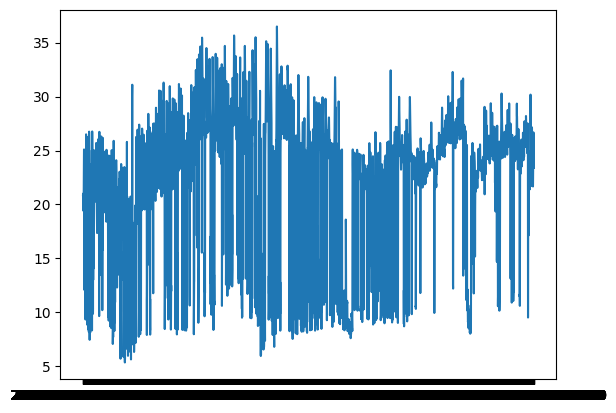

In [5]:
plt.plot(data['Datetime'], data['Hourly_Temp'])

In [6]:
### getting lag values for temperature
lookback = 7
shifted_data = prepare_dataframe_for_lstm(data, lookback)

In [7]:
shifted_data.head(5)

,Hourly_Temp,Hourly_Temp(t - 1),Hourly_Temp(t - 2),Hourly_Temp(t - 3),Hourly_Temp(t - 4),Hourly_Temp(t - 5),Hourly_Temp(t - 6),Hourly_Temp(t - 7)
Datetime,,,,,,,,
2022-01-04 07:00:00,19.500,19.800,20.1,20.4,20.65,20.867,21.000,20.867
2022-01-04 08:00:00,19.400,19.500,19.8,20.1,20.40,20.650,20.867,21.000
2022-01-04 09:00:00,19.500,19.400,19.5,19.8,20.10,20.400,20.650,20.867
2022-01-04 10:00:00,19.933,19.500,19.4,19.5,19.80,20.100,20.400,20.650
2022-01-04 11:00:00,20.750,19.933,19.5,19.4,19.50,19.800,20.100,20.400


In [8]:
# convert shifted dataframe to numpy
shifted_data_np = shifted_data.to_numpy()
shifted_data_np

array([[19.5  , 19.8  , 20.1  , ..., 20.867, 21.   , 20.867],
       [19.4  , 19.5  , 19.8  , ..., 20.65 , 20.867, 21.   ],
       [19.5  , 19.4  , 19.5  , ..., 20.4  , 20.65 , 20.867],
       ...,
       [24.6  , 25.183, 25.567, ..., 26.683, 26.183, 25.486],
       [23.986, 24.6  , 25.183, ..., 26.55 , 26.683, 26.183],
       [23.383, 23.986, 24.6  , ..., 26.16 , 26.55 , 26.683]])

##### Scale data using MinMax value

In [9]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_data_np = scaler.fit_transform(shifted_data_np)

In [10]:
shifted_data_np

array([[-0.09149278, -0.07223114, -0.0529695 , ..., -0.00372392,
         0.00481541, -0.00372392],
       [-0.09791332, -0.09149278, -0.07223114, ..., -0.0176565 ,
        -0.00372392,  0.00481541],
       [-0.09149278, -0.09791332, -0.09149278, ..., -0.03370787,
        -0.0176565 , -0.00372392],
       ...,
       [ 0.23595506,  0.27338684,  0.29804173, ...,  0.36969502,
         0.3375923 ,  0.29284109],
       [ 0.19653291,  0.23595506,  0.27338684, ...,  0.3611557 ,
         0.36969502,  0.3375923 ],
       [ 0.15781701,  0.19653291,  0.23595506, ...,  0.33611557,
         0.3611557 ,  0.36969502]])

In [11]:
# Assign X and y variables
X = shifted_data_np[:, 1:]
y = shifted_data_np[:,0]

In [12]:
X = dc(np.flip(X, axis = 1))

In [13]:
X.shape, y.shape

((7049, 7), (7049,))

 #### Splitting into train and test

In [14]:
split_index = int(len(X) * 0.8) # we are using the first 80% of X as train then the rest as test

In [15]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

In [16]:
# looking at the shape of each train and test variable
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5639, 7), (1410, 7), (5639,), (1410,))

#### Pytorch LSTM has an extra dimension, so we need to reshape to meet this requirement

In [17]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

In [18]:
# converting the above variables to pytorch tensors
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [19]:
# create a dataset for train and test using the Dataset classifier
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [21]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Instantiate the model

In [22]:
model = LSTM(1, 4, 1)
model.to(device)

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

#### Params

In [27]:
learning_rate = 0.001
num_epochs = 4
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Train Loop

In [24]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        X_batch = batch[0].to(device)
        y_batch = batch[1].to(device)

        output = model(X_batch)
        loss = loss_fn(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 99:
            avg_loss_across_batches = running_loss / loss
            print('Batch {0}, Loss: {1:.3f}'.format(batch_idx, avg_loss_across_batches))

            running_loss = 0.0
    

#### Test Loop

In [26]:
def test_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_idx, batch in enumerate(train_loader):
        X_batch = batch[0].to(device)
        y_batch = batch[1].to(device)

        with torch.no_grad():
            output = model(X_batch)
            loss = loss_fn(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batch = running_loss / len(test_loader)

    print('Test loss : {0:.3f}'.format(avg_loss_across_batch))
    print('***************************')

In [28]:
# training
for epoch in range(num_epochs):
    train_one_epoch()
    test_one_epoch()

Epoch: 1
Batch 99, Loss: 72.611
Batch 199, Loss: 227.643
Batch 299, Loss: 100.580
Val loss : 0.313
***************************
Epoch: 2
Batch 99, Loss: 110.581
Batch 199, Loss: 267.008
Batch 299, Loss: 138.388
Val loss : 0.201
***************************
Epoch: 3
Batch 99, Loss: 310.404
Batch 199, Loss: 144.089
Batch 299, Loss: 85.639
Val loss : 0.155
***************************
Epoch: 4
Batch 99, Loss: 133.518
Batch 199, Loss: 84.148
Batch 299, Loss: 162.105
Val loss : 0.142
***************************


#### Plotting

In [29]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

[]

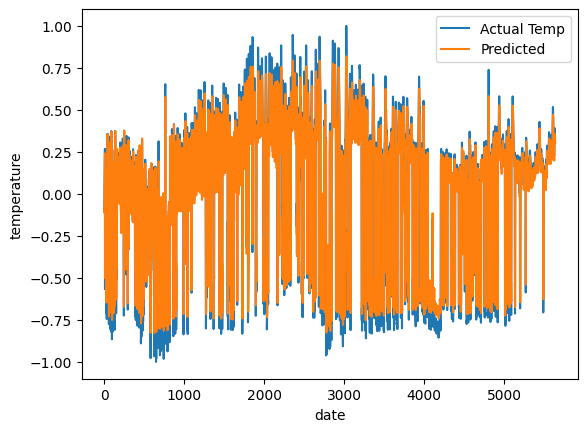

In [30]:
plt.plot(y_train, label= 'Actual Temp')
plt.plot(predicted, label = 'Predicted')
plt.xlabel('date')
plt.ylabel('temperature')
plt.legend()
plt.plot()

#### Transforming the data back into original shape for prediction

In [31]:
# we need to get the original scale back to the original for the plottings to match for the predictions
train_predictions = predicted.flatten() # making sure its one axis

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])

In [33]:
# getting the dimensions of the y_trains correctly
dummies = np.zeros((X_train.shape[0], lookback+1))

dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

[]

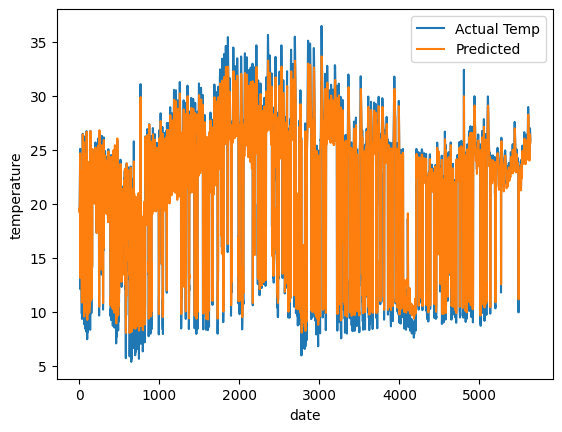

In [34]:
plt.plot(new_y_train, label= 'Actual Temp')
plt.plot(train_predictions, label = 'Predicted')
plt.xlabel('date')
plt.ylabel('temperature')
plt.legend()
plt.plot()

#### Test predictions to scale and plot

In [35]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten() # detach handles with torch.no_grad()

dummies = np.zeros((X_test.shape[0], lookback+1))

dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])

In [36]:
dummies = np.zeros((X_test.shape[0], lookback+1))

dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

[]

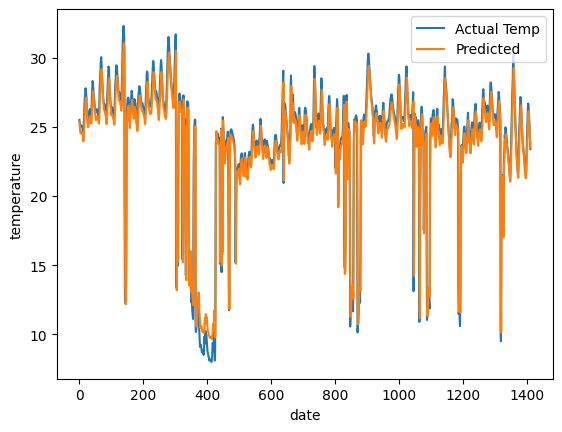

In [37]:
plt.plot(new_y_test, label= 'Actual Temp')
plt.plot(test_predictions, label = 'Predicted')
plt.xlabel('date')
plt.ylabel('temperature')
plt.legend()
plt.plot()